# How to use if you want to do the *INFERENCE*
- Download *checkpoints_baseline* from https://drive.google.com/drive/folders/1_13U4DmnYnTqc8FfvA7AL5pO5V5HDcTn. Make sure that the following path exists *"/baseline_experiments/checkpoints_baseline"*
- Run cells sequentially up to the *Training & Inference* section. Load Skil the training section by scrolling to the inference section
- Run the code blocks. You don't have to load models yourself, it is done automatically in the inference loops


If you want to train a model, just use the training section

In [1]:
# !mkdir checkpoints_baseline

In [1]:
%load_ext autoreload
%autoreload 2

### Load required packages

In [16]:
# !pip install torchmetrics  ### Run it if you dont have these libraries
# !pip install pytorch_lightning

In [6]:
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from utils import is_ne_in_df, to_numeric_and_downcast_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import ts_dataset as ds
import utils
import gc
import matplotlib.pyplot as plt

import torch
DEVICE=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

## Set up data & model parameters:

In [7]:

data_path = '../datasets/btc-usdt-1.csv'
timestamp_col_name = 'our_time'

print("Reading file in {}".format(data_path))

data = pd.read_csv(
    data_path, 
    parse_dates=[timestamp_col_name], 
    index_col=[timestamp_col_name], 
    infer_datetime_format=True,
    low_memory=False
)

# Make sure all "n/e" values have been removed from df. 
if is_ne_in_df(data):
    raise ValueError("data frame contains 'n/e' values. These must be handled")

data = to_numeric_and_downcast_data(data)

# Make sure data is in ascending order by timestamp
data.sort_values(by=[timestamp_col_name], inplace=True)

Reading file in ../datasets/btc-usdt-1.csv


In [8]:

price_data = pd.read_csv('../datasets/btc-usdt-1.csv')

input_data = ((price_data.bid_price + price_data.ask_price) / 2)

train_data, val_data = train_test_split(input_data.values, test_size=0.33, shuffle=False)
train_data.shape, val_data.shape

scaler = MinMaxScaler(feature_range=(-1, 1)) 
train_data = scaler.fit_transform(train_data.reshape(-1, 1)).reshape(-1)
val_data = scaler.transform(val_data.reshape(-1, 1)).reshape(-1)    

In [9]:
def get_dataloader(data, enc_seq_len=60, dec_seq_len=120, step_size=1, batch_first=True, batch_size=None):
    '''
    E.g. if you want the model to consider the past 100
    time steps in order to predict the future 50 
    time steps, window_size = 100+50 = 150
    
    Args:
    
        enc_seq_len: int, length of input given to encoder

        dec_seq_len: int, length of input given to decoder
        
        step_size: int, Step size, i.e. how many time steps does the moving window move at each step
            
    '''
    
    output_sequence_length = dec_seq_len # target sequence length. If hourly data and length = 48, you predict 2 days ahead

    window_size = enc_seq_len + output_sequence_length # used to slice data into sub-sequences
   
    indices = utils.get_indices_entire_sequence(
        data=data, 
        window_size=window_size, 
        step_size=step_size
    )

    # Making instance of custom dataset class
    data = ds.TransformerDataset(
        data=torch.tensor(data).unsqueeze(1).float(),
        indices=indices,
        enc_seq_len=enc_seq_len,
        dec_seq_len=dec_seq_len,
        target_seq_len=output_sequence_length
    )

    # Making dataloader
    return DataLoader(data, batch_size, shuffle=False, num_workers=40) # replace 40 with your number

In [10]:
BATCH_SIZE=256

enc_seq_len=30
dec_seq_len=5

train_loader = get_dataloader(train_data, enc_seq_len, dec_seq_len, batch_size=BATCH_SIZE)
val_loader = get_dataloader(val_data, enc_seq_len, dec_seq_len, batch_size=BATCH_SIZE)

From get_src_trg: data size = torch.Size([57888, 1])
From get_src_trg: data size = torch.Size([28512, 1])


# Training & Infernce

### Importing module with your model

In [11]:
import baseline as tst # replace with your model import
from model import SeqNet # needed

N_EPOCHS=120

backbone_net = tst.TimeSeriesTransformer(
    input_size=1, # num of input features
    dec_seq_len=dec_seq_len, # like in get_dataloader
    batch_first=True,
    num_predicted_features=1
)

model = SeqNet(
    backbone_net=backbone_net,
    forecast_window=dec_seq_len,
    enc_seq_len=enc_seq_len,
    n_epochs=N_EPOCHS, # needed for lr scheduling
).to(DEVICE)

# Training section. Skip it if you need the inference section

### Initializing logging and checkpointing params

In [43]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

wb_logger = pl.loggers.WandbLogger(
    name=f'TS_transformer_baseline|n_epochs={N_EPOCHS}|batch_size={BATCH_SIZE}|enc_seq_len={enc_seq_len}',
    project='sequential_data'
)

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    monitor='val_MSE', # name of SeqNet attribute
    filename='{epoch:02d}-{val_MSE:.3f}_3',
    mode='min'
)

trainer = pl.Trainer(
    max_epochs=N_EPOCHS,
    logger=wb_logger,
    accelerator='gpu',
    devices=1,
    benchmark=True,
    callbacks=[checkpoint_callback]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
import wandb

trainer.fit(
    model=model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

wandb.finish()

/home/v_chernyy/myvenv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:601: UserWarning: Checkpoint directory /raid/data/DA_GNN/jupyters/seq_data/crypto-transformers/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name      | Type                  | Params
----------------------------------------------------
0 | model     | TimeSeriesTransformer | 29.4 M
1 | criterion | MSELoss               | 0     
2 | mae       | L1Loss                | 0     
3 | train_mse | MeanSquaredError      | 0     
4 | val_mse   | MeanSquaredError      | 0     
----------------------------------------------------
29.4 M    Trainable params
0         Non-trainable params
29.4 M    Total params
117.713   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Inference section

In [12]:
list_of_checkpoints = [
#     'checkpoints_baseline/epoch=00-val_mse=0.000_1.ckpt',
#     'checkpoints_baseline/epoch=119-val_mse=0.000_2.ckpt',
#     'checkpoints_baseline/epoch=119-val_MSE=1.501_3.ckpt',
#     'checkpoints_baseline/epoch=119-val_MSE=1.503_4.ckpt',
    'checkpoints_baseline/epoch=119-val_MSE=1.505_5.ckpt',
#     'checkpoints_baseline/epoch=42-val_MSE=1.497_6.ckpt'
]
hyperparams = [
#     1,
#     15,
#     30,
#     60,
    120,
#     240
]

### Memory footprint

##### for every context length 'enc_seq_len' (which corresponds to a particular checkpoint), run a single inference loop and measure how much memory is used

In [51]:
print('Warm up...')
enc_seq_len = 30
val_loader = get_dataloader(val_data, enc_seq_len, dec_seq_len, batch_size=BATCH_SIZE)
batch = next(iter(val_loader))
src = batch[0].to(DEVICE)
tgt = batch[1].to(DEVICE)

backbone_net = tst.TimeSeriesTransformer(
    input_size=1, # num of input features
    dec_seq_len=dec_seq_len, # like in get_dataloader
    batch_first=True,
    num_predicted_features=1
)

model = SeqNet(
    backbone_net=backbone_net,
    forecast_window=dec_seq_len,
    enc_seq_len=enc_seq_len,
    n_epochs=N_EPOCHS, # needed for lr scheduling
).to(DEVICE)
with torch.no_grad():
    model.load_state_dict(torch.load(f'{list_of_checkpoints[0]}')['state_dict'])
    src_mask, tgt_mask = model.src_mask.to(model.device), model.tgt_mask.to(model.device)
del src, tgt, batch, src_mask, tgt_mask, backbone_net, model; torch.cuda.empty_cache(); gc.collect()
print('Memory footprint')
for enc_seq_len, checkpoint in zip(hyperparams, list_of_checkpoints):
    val_loader = get_dataloader(val_data, enc_seq_len, dec_seq_len, batch_size=BATCH_SIZE)
    batch = next(iter(val_loader))
    batch = [x.cuda() for x in batch]
    backbone_net = tst.TimeSeriesTransformer(
        input_size=1, # num of input features
        dec_seq_len=dec_seq_len, # like in get_dataloader
        batch_first=True,
        num_predicted_features=1
    )

    model = SeqNet(
        backbone_net=backbone_net,
        forecast_window=dec_seq_len,
        enc_seq_len=enc_seq_len,
        n_epochs=N_EPOCHS, # needed for lr scheduling
    ).to(DEVICE)
    
    before_inference = torch.cuda.mem_get_info()[0]/1.049e+6 # converst bytes to mebibyte - a standard measure used in nvidia-smi
    with torch.no_grad():
        model.load_state_dict(torch.load(f'{checkpoint}')['state_dict'])
        y_pred = model(batch).flatten()
    after_inference = torch.cuda.mem_get_info()[0]/1.049e+6
    print(f'- - - - Seq length {enc_seq_len}, Memory used = {before_inference - after_inference}')
    del model; torch.cuda.empty_cache(); gc.collect()

Warm up...
From get_src_trg: data size = torch.Size([28512, 1])
Memory footprint
From get_src_trg: data size = torch.Size([28512, 1])
- - - - Seq length 30, Memory used = 495.7995195424214


### Inference speed (with warm-up)

In [19]:
import time

In [20]:
def benchmark(model, src, tgt, src_mask, tgt_mask, dtype='fp32', nwarmup=50, nruns=1000, device='cuda', period=100):
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model.model(src, tgt, src_mask, tgt_mask)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            features = model.model(src, tgt, src_mask, tgt_mask)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%period==0:
                print('Iteration %d/%d, ave batch time %.2f ms'%(i, nruns, np.mean(timings)*nruns))

    print("Output features size:", features.size())

    print('Average batch time: %.2f ms'%(np.mean(timings)*nruns))

    return np.mean(timings)*nruns

In [52]:
for enc_seq_len, checkpoint in zip(hyperparams, list_of_checkpoints):
    print(f'---- encoder seq len {enc_seq_len}')
    val_loader = get_dataloader(val_data, enc_seq_len, dec_seq_len, batch_size=BATCH_SIZE)
    batch = next(iter(val_loader))
    src = batch[0].to(DEVICE)
    tgt = batch[1].to(DEVICE)

    backbone_net = tst.TimeSeriesTransformer(
        input_size=1, # num of input features
        dec_seq_len=dec_seq_len, # like in get_dataloader
        batch_first=True,
        num_predicted_features=1
    )

    model = SeqNet(
        backbone_net=backbone_net,
        forecast_window=dec_seq_len,
        enc_seq_len=enc_seq_len,
        n_epochs=N_EPOCHS, # needed for lr scheduling
    ).to(DEVICE)
    with torch.no_grad():
        model.load_state_dict(torch.load(f'{checkpoint}')['state_dict'])
        src_mask, tgt_mask = model.src_mask.to(model.device), model.tgt_mask.to(model.device)
        benchmark(model, src, tgt, src_mask, tgt_mask)
    del model; torch.cuda.empty_cache(); gc.collect()

---- encoder seq len 30
From get_src_trg: data size = torch.Size([28512, 1])
Warm up ...
Start timing ...
Iteration 100/1000, ave batch time 30.93 ms
Iteration 200/1000, ave batch time 30.95 ms
Iteration 300/1000, ave batch time 30.96 ms
Iteration 400/1000, ave batch time 30.97 ms
Iteration 500/1000, ave batch time 30.98 ms
Iteration 600/1000, ave batch time 30.99 ms
Iteration 700/1000, ave batch time 31.01 ms
Iteration 800/1000, ave batch time 31.02 ms
Iteration 900/1000, ave batch time 31.03 ms
Iteration 1000/1000, ave batch time 31.04 ms
Output features size: torch.Size([256, 5, 1])
Average batch time: 31.04 ms


### Model predictions quality

In [28]:
batch = next(iter(get_dataloader(val_data, enc_seq_len=120, dec_seq_len=5, step_size=5, batch_first=True, batch_size=80)))

From get_src_trg: data size = torch.Size([28512, 1])


In [29]:
backbone_net = tst.TimeSeriesTransformer(
    input_size=1, # num of input features
    dec_seq_len=5, # like in get_dataloader
    batch_first=True,
    num_predicted_features=1
)

model = SeqNet(
    backbone_net=backbone_net,
    forecast_window=5,
    enc_seq_len=120,
    n_epochs=N_EPOCHS, # needed for lr scheduling
).to(DEVICE)

model.load_state_dict(torch.load(list_of_checkpoints[-1])['state_dict'])

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.78 GiB total capacity; 4.17 GiB already allocated; 3.56 MiB free; 4.20 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [24]:
batch = [x.cuda() for x in batch]

In [27]:
torch.cuda.empty_cache()
import gc
gc.collect()

del batch
del model

NameError: name 'batch' is not defined

In [25]:
y_pred_unscaled = scaler.inverse_transform(
    model(batch).detach().cpu().numpy().reshape(1, -1)
).squeeze()

RuntimeError: CUDA out of memory. Tried to allocate 142.00 MiB (GPU 0; 15.78 GiB total capacity; 4.13 GiB already allocated; 43.56 MiB free; 4.16 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [86]:
y_true = scaler.inverse_transform(
    batch[-1].flatten().detach().cpu().numpy().reshape(1, -1)
).squeeze()

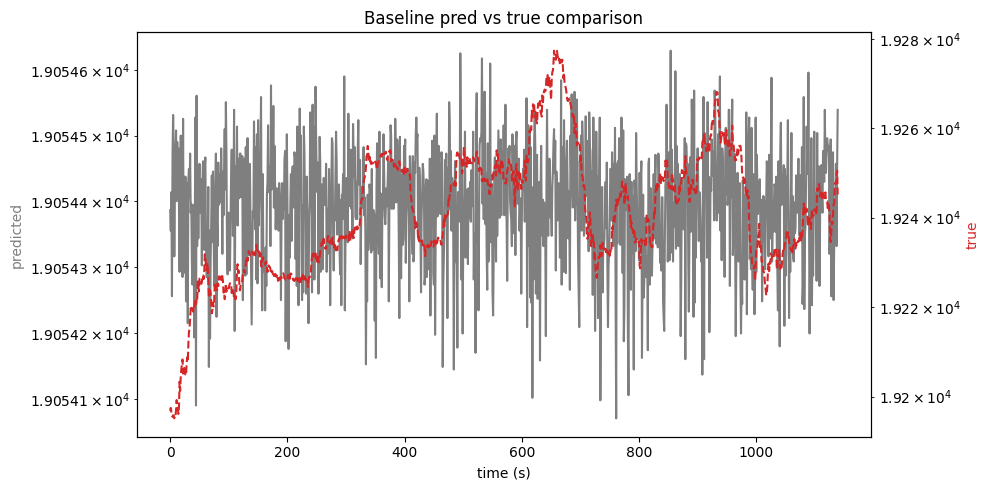

In [40]:
_, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:gray'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('predicted', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(y_pred_unscaled, color=color)
ax1.set_yscale('log')

ax2 = ax1.twinx() 

color = 'tab:red'
ax2.set_xlabel('time (s)')
ax2.set_ylabel('true', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(y_true, '--', color=color)
ax2.set_yscale('log')

plt.title('Baseline pred vs true comparison')

plt.tight_layout()
plt.savefig('baseline', dpi=1000)

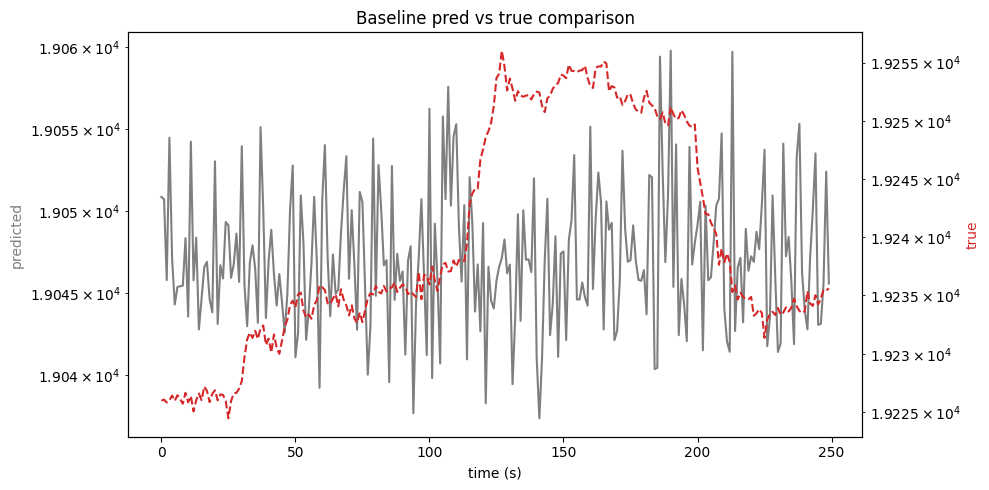

In [87]:
_, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:gray'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('predicted', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(y_pred_unscaled, color=color)
ax1.set_yscale('log')

ax2 = ax1.twinx() 

color = 'tab:red'
ax2.set_xlabel('time (s)')
ax2.set_ylabel('true', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(y_true, '--', color=color)
ax2.set_yscale('log')

plt.title('Baseline pred vs true comparison')

plt.tight_layout()
plt.savefig('baseline', dpi=1000)